Start with in-game stats dataset of 10754 players (not including goalkeepers) from 2022-2023 season.
After merging with player description dataset and preprocessing, drops to 7400 rows (unique players).
Then, keep only players that have played at least 8 games (1/4 of season).
Split dataset into 4, 1 for each position group.
Import 4 datasets regarding attackers, midfielders, defenders, and goalies.

In [1]:
import pandas as pd
import numpy as np

att = pd.read_csv("2022_forwards.csv").drop(['Unnamed: 0.1','Unnamed: 0'], axis=1)
best_attackers = ['Erling Haaland','Kylian Mbappé', 'Harry Kane', 'Alexandre Lacazette','Victor Osimhen',
                  'Lionel Messi', 'Jonathan David', 'Lautaro Martínez','Robert Lewandowski',
                  'Karim Benzema','Wissam Ben Yedder','Roberto Firmino','Mohamed Salah','Phil Foden',
                  'Antoine Griezmann','Rafael Leão','Marcus Rashford','Dušan Vlahović', 'Alexander Isak', 
                  'Randal Kolo Muani','Gabriel Jesus','Khvicha Kvaratskhelia','Bukayo Saka','Ademola Lookman', 
                  'Folarin Balogun','Gabriel Martinelli', 'Cody Gakpo', 'Darwin Núñez', 'Sébastien Haller',
                  'Gonçalo Ramos', 'Ollie Watkins','Ivan Toney', 'Olivier Giroud', 'Santiago Giménez', 
                  'Elye Wahi','Evan Ferguson', 'Rodrygo', 'Serge Gnabry', 'Ousmane Dembélé', 'Marcus Thuram']

for index, row in att.iterrows():
    if row['Player'] in best_attackers:
        att.loc[index,'Success'] = 1
    else:
        att.loc[index,'Success'] = 0

In [2]:
from sklearn.model_selection import train_test_split

X = att.drop('Success', axis=1)
y = att['Success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_new = X_train.drop(['Squad', 'DoB', 'Player', 'Position', 'UID','Born', 'Club', "Preferred Foot", 'Nat', 'Based'], axis=1)
X_train_new.columns = X_train_new.columns.str.strip()

X_test_new = X_test.drop(['Squad', 'DoB', 'Player', 'Position', 'UID','Born', 'Club', "Preferred Foot", 'Nat', 'Based'], axis=1)
X_test_new.columns = X_test_new.columns.str.strip()

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_new), columns=X_train_new.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_new), columns=X_test_new.columns)

# Define class weights
class_weights = {0: 1, 1: 12}

# Define the models
models = {
    'Logistic Regression - Newton': LogisticRegression(solver='newton-cg',penalty=None,max_iter=1000,class_weight=class_weights), 
    'Logistic Regression - lbgfs': LogisticRegression(solver='lbfgs',penalty=None,max_iter=2000,class_weight=class_weights), 
    'Logistic Regression - sag': LogisticRegression(solver='sag',penalty=None,max_iter=2000,class_weight=class_weights), 
    'Logistic Regression - saga': LogisticRegression(solver='saga',penalty=None,max_iter=3000,class_weight=class_weights),
    'Logistic Regression' : LogisticRegression(class_weight=class_weights),
    'SVM': SVC(kernel='linear',probability=True,class_weight=class_weights)
}

for model_name, model in models.items():

    model.fit(X_train_scaled, y_train)

    # Calculate AIC/BIC
    log_likelihood = np.sum(y_test * np.log(model.predict_proba(X_test_scaled)[:, 1]) + (1 - y_test) * np.log(1 - model.predict_proba(X_test_scaled)[:, 1]))
    
    num_params = len(model.coef_[0]) + 1
    aic = -2 * log_likelihood + 2 * num_params
    bic = -2 * log_likelihood + num_params * np.log(len(y_test))

    # Print AIC/BIC values
    print("\nAIC for " + model_name + ": " + str(aic))
    print("BIC for " + model_name + ": " + str(bic))


AIC for Logistic Regression - Newton: 144.00787603297255
BIC for Logistic Regression - Newton: 245.95275707850513

AIC for Logistic Regression - lbgfs: 144.0057560314195
BIC for Logistic Regression - lbgfs: 245.9506370769521


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



AIC for Logistic Regression - sag: 177.3361583983975
BIC for Logistic Regression - sag: 279.28103944393007

AIC for Logistic Regression - saga: 144.91379191026124
BIC for Logistic Regression - saga: 246.85867295579382

AIC for Logistic Regression: 139.31173140007746
BIC for Logistic Regression: 241.25661244561005

AIC for SVM: 97.9515492137782
BIC for SVM: 199.89643025931076


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [4]:
import shap

#Fit logistic regression model and compute shap values
masker = shap.maskers.Independent(data = X_train_scaled)
model = SVC(kernel='linear',probability=True,class_weight=class_weights)
model.fit(X_train_scaled, y_train)
explainer = shap.LinearExplainer(model, masker=masker)
shap_values = explainer(X_test_scaled)

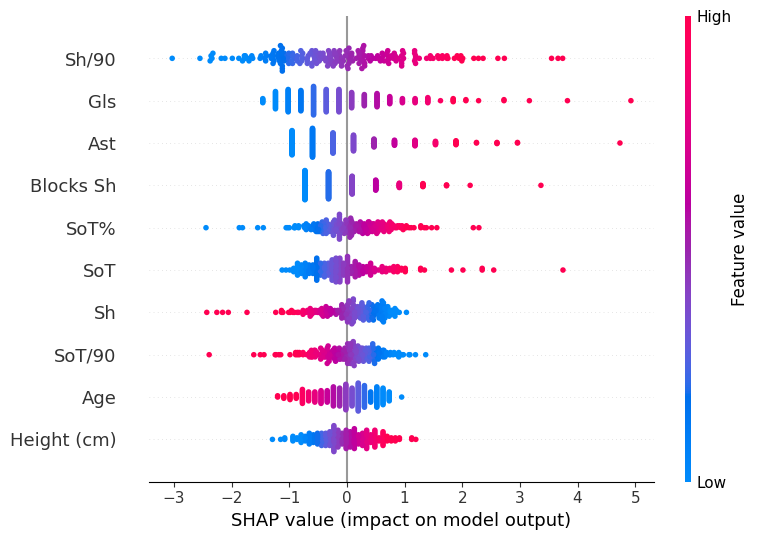

In [5]:
import matplotlib.pyplot as plt

shap.summary_plot(shap_values, max_display=10, show=False)
plt.savefig("shap_summary.png",dpi=700)

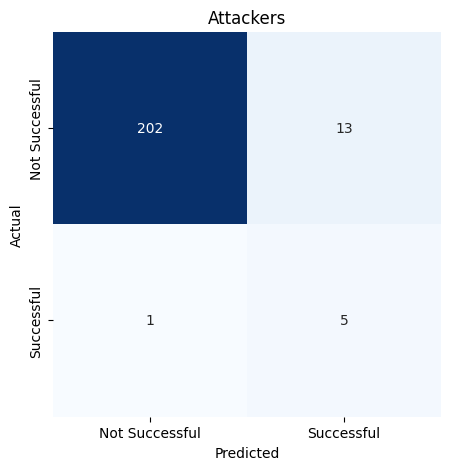

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Successful', 'Successful'],
            yticklabels=['Not Successful', 'Successful'])
plt.title(f'Attackers')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", round(precision,3))

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred)
print("Recall:", round(recall,3))

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-Score:", round(f1,3))

Accuracy: 0.937
Precision: 0.278
Recall: 0.833
F1-Score: 0.417
